In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.losses import *
from tensorflow.keras.models import *
from tensorflow.keras.metrics import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from PIL import Image, ImageEnhance
from tqdm import tqdm
import random

In [2]:
x_train_paths = []
y_train_paths = []
x_val_paths = []
y_val_paths = []

all_paths = []
all_labels = []
data_dir = 'dataset/'
for label in os.listdir(data_dir):
    for image in os.listdir(data_dir+label):
        all_paths.append(data_dir+label+'/'+image)
        all_labels.append(label)
all_paths, all_labels = shuffle(all_paths, all_labels)

x_train_paths = all_paths[:5000]
y_train = all_labels[:5000]
x_val_paths = all_paths[5000:]
y_val = all_labels[5000:]

In [3]:
def augment_image(image):
    image = Image.fromarray(np.uint8(image))
    image = ImageEnhance.Brightness(image).enhance(random.uniform(0.6,1.4))
    image = ImageEnhance.Contrast(image).enhance(random.uniform(0.6,1.4))
    image = np.array(image)/255.0
    return image

In [4]:
def open_images(paths):
    images = []
    for path in paths:
        image = load_img(path, target_size=(128,128))
        image = augment_image(image)
        images.append(image)
    return np.array(images)

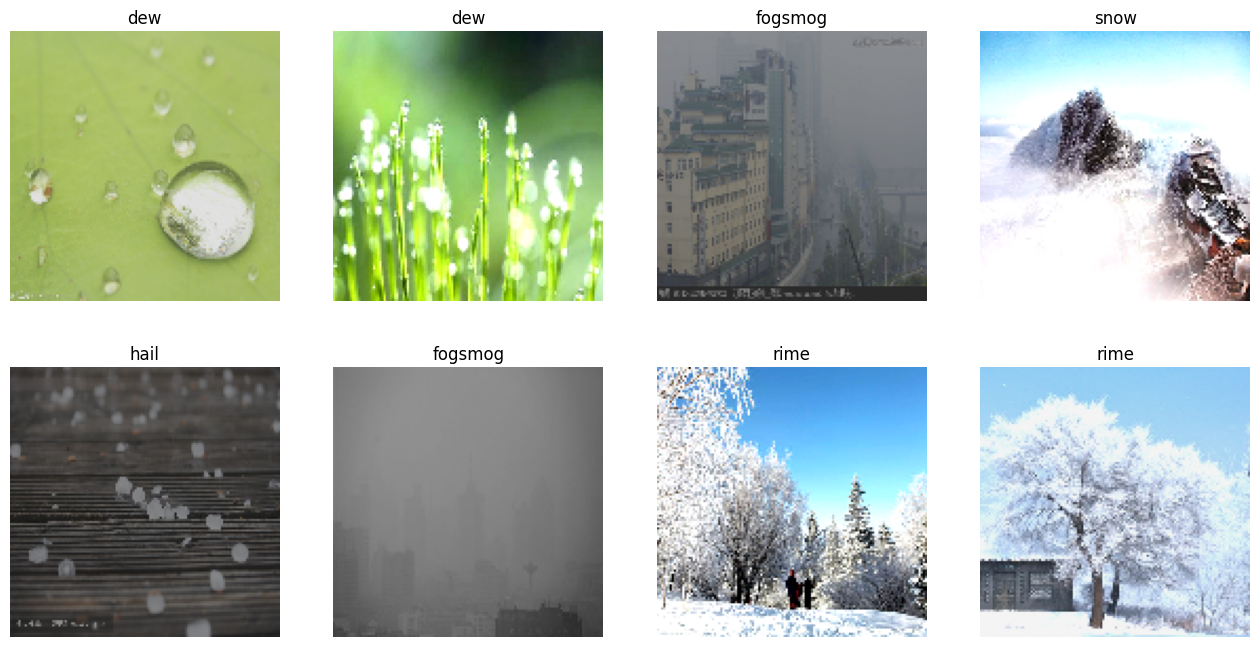

In [5]:
num_images = 9
images = open_images(x_train_paths[:num_images])
fig = plt.figure(figsize=(16, round(num_images/4)*4))
for x in range(1, num_images):
    fig.add_subplot(int(num_images/4), 4, x)
    plt.axis('off')
    plt.title(y_train[x])
    plt.imshow(images[x])
plt.show()

In [6]:
unique_labels = os.listdir('dataset/')
def encode_label(labels):
    encoded = []
    for x in labels:
        encoded.append(unique_labels.index(x))
    return np.array(encoded)

def decode_label(labels):
    decoded = []
    for x in labels:
        decoded.append(unique_labels[x])
    return np.array(decoded)

In [7]:
def data_gen(paths, labels, batch_size=12):
    
    if len(paths)!=len(labels):
        raise Exception('The length of paths is ',len(paths), ' but the length of labels is ', len(labels))
    
    for x in range(0, len(paths), batch_size):
        batch_paths = paths[x:x+batch_size]
        batch_images = open_images(batch_paths)
        batch_labels = labels[x:x+batch_size]
        batch_labels = encode_label(batch_labels)
        yield batch_images, batch_labels

In [8]:
vgg16 = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')
# Set all layers to non-trainable
for layer in vgg16.layers:
    layer.trainable = False

In [9]:
model = Sequential()
model.add(Input(shape=(128,128,3)))
model.add(vgg16)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(768, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(len(unique_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 768)               6292224   
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               196864    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
batch_size=12
steps = int(len(x_train_paths)/batch_size)
epochs=16
for _ in range(epochs):
    model.fit(data_gen(x_train_paths, y_train, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

 36/416 [=>............................] - ETA: 5:05 - loss: 0.9274 - accuracy: 0.6620

KeyboardInterrupt: 

In [ ]:
batch_size=12
steps = int(len(x_val_paths)/batch_size)
y_pred = []
y_true = []
for x,y in tqdm(data_gen(x_val_paths, y_val, batch_size=batch_size), total=steps):
    pred = model.predict(x)
    pred = np.argmax(pred, axis=-1)
    for i in pred:
        y_pred.append(i)
    for i in y:
        y_true.append(i)

In [ ]:
print(classification_report(y_true, y_pred))

In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np 
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
datagen = ImageDataGenerator(
        samplewise_center=True,  
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True,
        validation_split=0.2) 

In [ ]:
train=datagen.flow_from_directory(  "dataset",  
                                    target_size=(224, 224), 
                                    color_mode='rgb',
                                    shuffle=True,
                                    seed=42,
                                    class_mode='categorical', 
                                    batch_size=32,
                                    subset="training"
)
validation=datagen.flow_from_directory( "dataset",  
                                    target_size=(224, 224), 
                                    shuffle=True,
                                    seed=42,
                                    color_mode='rgb', 
                                    class_mode='categorical', 
                                    batch_size=32,
                                    subset='validation'
)

In [ ]:
class_names = list(train.class_indices.keys())
n_classes = len(class_names)
class_names

In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',  
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
base_model.trainable = False#freezing
inputs = keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = Dense(11, activation='softmax')(x)
model = keras.Model(inputs, outputs)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

In [ ]:
class_names[np.argmax(make_predictions("dataset/dew/2208.jpg"))]

In [ ]:
class_names[np.argmax(make_predictions("dataset/snow/0832.jpg"))]

In [ ]:
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

In [ ]:
root_path = 'dataset'
class_dis = [len(os.listdir( root_path+ "/" + name)) for name in class_names]

In [ ]:
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution")
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(
    x=class_names, 
    y=class_dis
)
plt.axhline(np.mean(class_dis), alpha=0.5, linestyle='--', color='k', label="Mean")
plt.title("Class Distribution")
plt.legend(fontsize=15)
plt.show()

In [ ]:
from tensorflow.keras.applications import ResNet152V2
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout, Conv2D, MaxPool2D, BatchNormalization, Layer, ReLU, Add, InputLayer, Multiply
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from keras.preprocessing.image import ImageDataGenerator as IDG

In [ ]:
train_gen = IDG(rescale=1./255, horizontal_flip=True, rotation_range=20, validation_split=0.2)

train_ds = train_gen.flow_from_directory(root_path, target_size=(256,256), class_mode="binary", subset='training', shuffle=True, batch_size=32)
valid_ds = train_gen.flow_from_directory(root_path, target_size=(256,256), class_mode="binary", subset='validation', shuffle=True, batch_size=32)

In [ ]:
name = 'resnet'

base_model = ResNet152V2(include_top=False, input_shape=(256,256,3))
base_model.trainable = False


model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(n_classes, activation="softmax")
])


model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)


cbs = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(name + ".h5", save_best_only=True)
]

In [ ]:
model.fit(train_ds, callbacks=cbs, validation_data=valid_ds)

In [ ]:
model = load_model('resnet.h5')

In [ ]:
model.evaluate(valid_ds)

In [ ]:
data_dir = 'dataset/'
filepaths = []
labels = []

folds = os.listdir(data_dir)
for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)
        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
df = pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
df

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.6, shuffle= True, random_state= 123)

In [ ]:
batch_size = 64
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

def scalar(img):
    return img

tr_gen = ImageDataGenerator(preprocessing_function= scalar)
ts_gen = ImageDataGenerator(preprocessing_function= scalar)
train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= test_batch_size)

In [ ]:
from tensorflow.python.keras import regularizers

In [ ]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

In [ ]:
   # number of all epochs in training
history = model.fit(x= train_gen, epochs=3, verbose= 1, validation_data= valid_gen, 
                    validation_steps= None, shuffle= False)

In [ ]:
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'
# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')
plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

In [ ]:
ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

In [ ]:
preds = model.predict_generator(test_gen)   #start of prediction 
y_pred = np.argmax(preds, axis=1)

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()